# Training Object Detection Models using Detectron2 library

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
# detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode


from utils import init_notebook
%aimport datasets, datasets.data_transform, datasets.data_visualization
from datasets import data_visualization,data_transform

# other libs (other necessary imports in Colab file to make the list shorter here)
import os
import glob
from pathlib import Path
import cv2
import torch, torchvision
import torchvision.transforms as transforms

HOME = Path(os.getcwd()).parents[0]
HOME

WindowsPath('c:/Users/Geomatique/Documents/map-symbols-detection-in-historical-maps/notebooks/Sutty_pipeline')

### Import Data from YOLO Format (Optional, we use mainly the importation in COCO format)
This method due to the way the annotations are represented cannot keep names for the labels but only their indexes

In [ ]:
from datasets.data_transform import detr_create_data_pairs

input_path = (HOME).as_posix()+"/data/yolo_datasets/yolass_f52_synth_4000_6000_3000_1000_1280_wlabels_aug/"

detectron_img_path = (HOME).as_posix()+"/data/yolo_datasets/yolass_f52_synth_4000_6000_3000_1000_1280_wlabels_aug/"
detectron_annot_path = (HOME).as_posix()+"/data/yolo_datasets/yolass_f52_synth_4000_6000_3000_1000_1280_wlabels_aug/"

train = detr_create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'train')
val = detr_create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'val')
train

In [ ]:
from datasets.data_transform import detr_create_coco_format
train_list = detr_create_coco_format(train)
val_list = detr_create_coco_format(val)

In [ ]:
import yaml
# To access to the labels of the categories we need to read the yaml file that contains the names of the classes
with open(input_path+'data.yaml', 'r') as file:
    data = yaml.load(file, Loader=yaml.FullLoader)
classes= data['names']
classes

In [ ]:
# We register the train and validation datasets as detectron2 datasets
for catalog_name, file_annots in [("train", train_list), ("val", val_list)]:
    DatasetCatalog.register("my_dataset_"+catalog_name, lambda file_annots = file_annots: file_annots)
    MetadataCatalog.get(catalog_name).set(thing_classes=classes)    # The information about the classes is stored in the metadata

metadata = MetadataCatalog.get("my_dataset_train") 

### Import Data from COCO Format

In [3]:
#define paths
annotations_path = (HOME).as_posix()+"/data/coco_datasets/Cocass_aug/ffull_detailed.json"
image_root = (HOME).as_posix()+"/data/coco_datasets/Cocass_aug/images"

# The paths where the training and validation annotations will be stored
# The annotations read when registering the datasets are from those files
store_train_path = (HOME).as_posix()+"/data/coco_datasets/Cocass_aug/ffull_detailed_train.json"
store_val_path = (HOME).as_posix()+"/data/coco_datasets/Cocass_aug/fraw_detailed_val.json"

In [4]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import load_coco_json
from datasets.data_transform import det2_splitter

register_coco_instances("my_dataset", {}, annotations_path, image_root)
# Load the json file into the dataset (if not the categories are not taken into account)
load_coco_json(annotations_path, image_root, "my_dataset")

# train_split_size = 0.8  # 80% of the data is used for training
# Split the dataset into training and validation
# det2_splitter(
#     annotations_path,
#     store_train_path,
#     store_val_path,
#     train_split_size=train_split_size
# )

register_coco_instances("my_dataset_train", {},store_train_path, image_root)
load_coco_json(store_train_path, image_root, "my_dataset_train")
register_coco_instances("my_dataset_val", {}, store_val_path , image_root)
load_coco_json(store_val_path, image_root, "my_dataset_val")

# If the is are not linear, a remapping is done automatically

WARNING [08/26 18:39:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/26 18:39:47 d2.data.datasets.coco]: Loaded 6978 images in COCO format from c:/Users/Geomatique/Documents/map-symbols-detection-in-historical-maps/notebooks/Sutty_pipeline/data/coco_datasets/Cocass_aug/ffull_detailed.json
WARNING [08/26 18:39:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/26 18:39:48 d2.data.datasets.coco]: Loaded 6383 images in COCO format from c:/Users/Geomatique/Documents/map-symbols-detection-in-historical-maps/notebooks/Sutty_pipeline/data/coco_datasets/Cocass_aug/ffull_detailed_train.json
WARNING [08/26 18:39:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/26 18:39:48 d2.data.datasets.coco]: Loaded 595 images in COCO format from c:/Users/Geomatique/Documents/map-symbols-detection-

[{'file_name': 'c:/Users/Geomatique/Documents/map-symbols-detection-in-historical-maps/notebooks/Sutty_pipeline/data/coco_datasets/Cocass_aug/images\\f006_0.jpg',
  'height': 1280,
  'width': 1280,
  'image_id': 1,
  'annotations': [{'bbox': [0.0,
     377.46877250494435,
     86.90481438644929,
     170.6707662125118],
    'category_id': 14,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [847.1795000563725,
     463.3606529044919,
     203.79310798068764,
     170.08528543636203],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [182.69356343022082,
     756.6724696597084,
     194.19577956333524,
     199.67073475802317],
    'category_id': 3,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [403.110700311081,
     595.3662669863552,
     160.37903501285473,
     113.03198012849316],
    'category_id': 5,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [432.99098640994634,
     1099.7548027243465,
     152.80980209913105,
     110.586040992289

### Visualize some data

WARNING [08/26 18:39:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/26 18:39:58 d2.data.datasets.coco]: Loaded 595 images in COCO format from c:/Users/Geomatique/Documents/map-symbols-detection-in-historical-maps/notebooks/Sutty_pipeline/data/coco_datasets/Cocass_aug/fraw_detailed_val.json


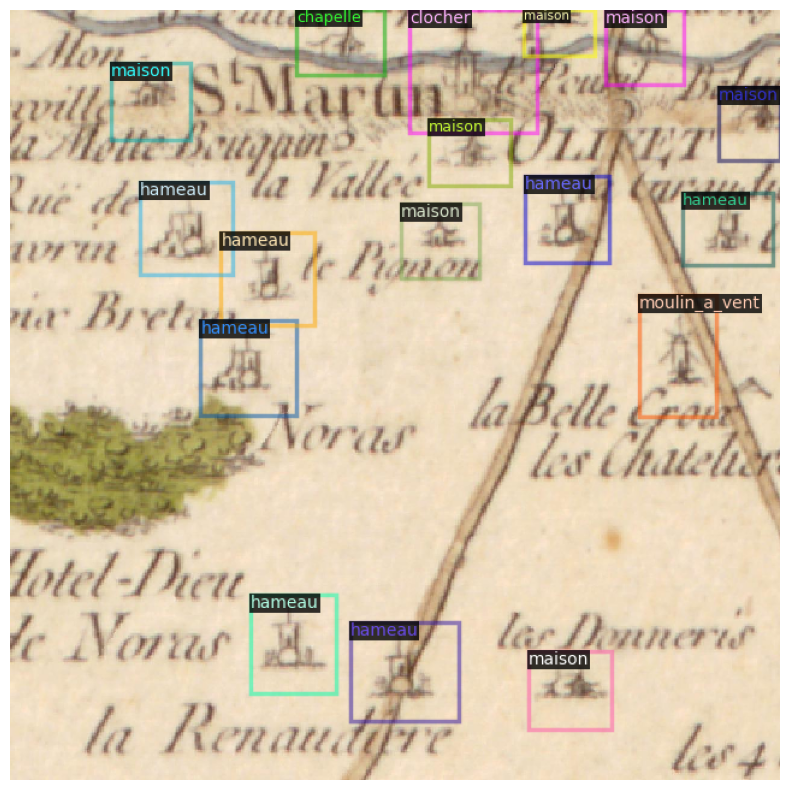

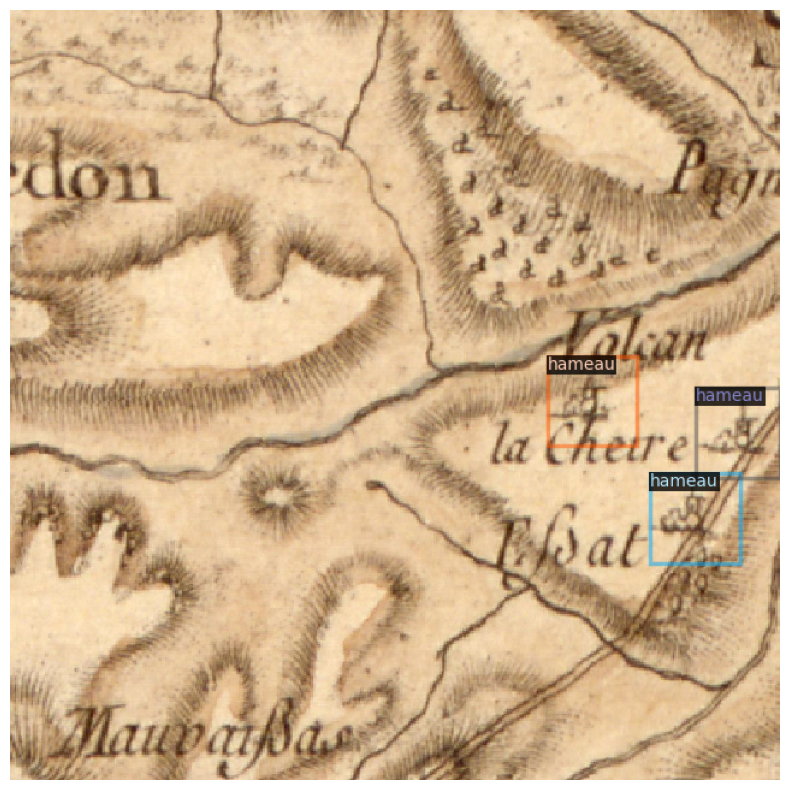

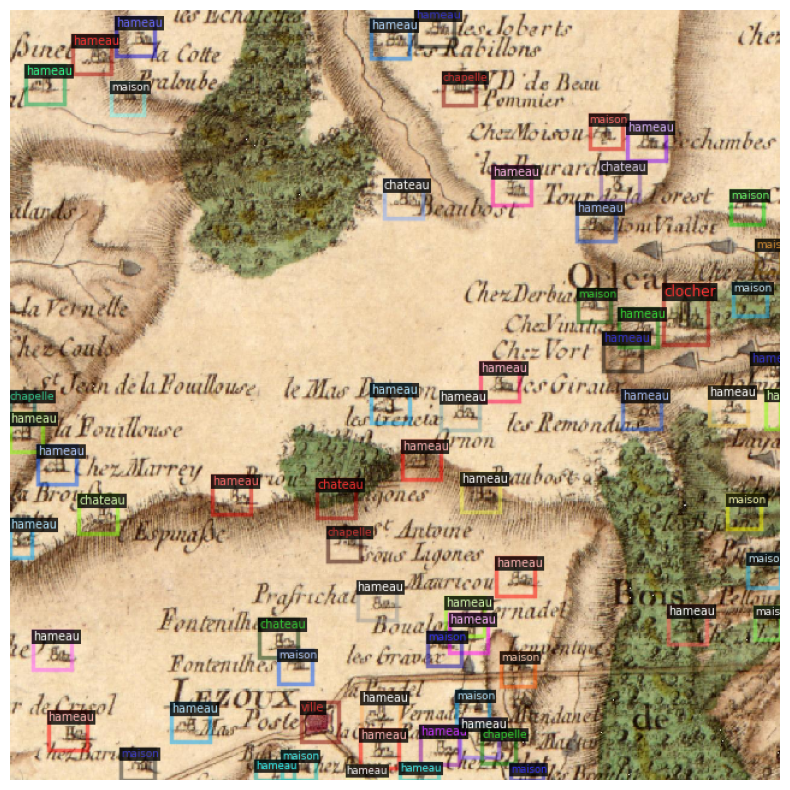

In [5]:
from datasets.data_visualization import det2_dataset_visualize

det2_dataset_visualize("my_dataset_val",3)

## Train

In [6]:
max_iter=100000 # By steps rather than epochs 
# iterations have been put by testing  and may not be the best value

cfg = get_cfg() # base configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
# or "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl" may be updated
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 5000
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = max_iter # (train_size / batch_size) * 100

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("my_dataset_train").thing_classes)
cfg.SOLVER.STEPS = (20500, )

cfg.OUTPUT_DIR = "../runs/detectron2/faster_rcnn_R_50_FPN_3x"   # The directory where the model will be stored


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[08/26 18:40:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (18, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (68, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (68,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

#### To save the configs

In [7]:
#save the config file
cfg_file = '../models/detectron2/config4.yaml'
with open(cfg_file, 'w') as file:
    file.write(cfg.dump())

#### Training

In [8]:
import time as t
s1 = t.time()
try:
  trainer.train()
except:
  None
s2 = t.time()
print(s2-s1)

[08/26 18:40:39 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\Geomatique\Documents\map-symbols-detection-in-historical-maps\ehess_env\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/26 18:40:49 d2.utils.events]:  eta: 4:19:18  iter: 19  total_loss: 6.275  loss_cls: 2.617  loss_box_reg: 0.1763  loss_rpn_cls: 2.917  loss_rpn_loc: 0.3748    time: 0.1613  last_time: 0.1383  data_time: 0.1917  last_data_time: 0.0006   lr: 1.9981e-05  max_mem: 1675M
[08/26 18:40:54 d2.utils.events]:  eta: 4:00:26  iter: 39  total_loss: 3.282  loss_cls: 2.112  loss_box_reg: 0.2168  loss_rpn_cls: 0.5131  loss_rpn_loc: 0.3045    time: 0.1550  last_time: 0.1271  data_time: 0.0007  last_data_time: 0.0007   lr: 3.9961e-05  max_mem: 1809M
[08/26 18:40:57 d2.utils.events]:  eta: 4:00:23  iter: 59  total_loss: 2.237  loss_cls: 1.253  loss_box_reg: 0.3955  loss_rpn_cls: 0.2866  loss_rpn_loc: 0.2152    time: 0.1522  last_time: 0.1400  data_time: 0.0007  last_data_time: 0.0006   lr: 5.9941e-05  max_mem: 1809M
[08/26 18:41:00 d2.utils.events]:  eta: 4:07:37  iter: 79  total_loss: 2.236  loss_cls: 1.14  loss_box_reg: 0.6877  loss_rpn_cls: 0.2173  loss_rpn_loc: 0.1942    time: 0.1519  last_time: 0